In [1]:
import cv2
import numpy as np
from scipy import ndimage
from copy import copy
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Set up graph
matplotlib.rcParams.update({'font.size': 11})

In [3]:
def threshold_image(frame_in, threshold):
  """Compare the intensity of each pixel in an image with a threshold value. If the pixel intensity is above the threshold, it is set to the difference between the pixel and threshold values, otherwise, it is set to zero"""
  fraction = 1.0 - threshold
  frame_threshold = copy(frame_in)
  frame_threshold += ((frame_threshold.max() - frame_threshold.min()) * fraction) - frame_threshold.max()
  frame_threshold = cv2.threshold(frame_threshold, 0, 0, cv2.THRESH_TOZERO)[1]
  return frame_threshold

In [4]:
def spot_centre(frame_threshold):
  """Perform a centre of mass operation to find the centre of a light spot in a thresholded image"""
  peak = ndimage.measurements.center_of_mass(frame_threshold)
  peak = (peak[1], peak[0])
  return peak

In [5]:
def spot_radius(frame_threshold, peak):
  """Calculate the distance between the spot centre and every high pixel in a thresholded image and return the maximum distance"""
  frame_bool = copy(frame_threshold)
  xp, yp = np.meshgrid(np.arange(np.shape(frame_bool)[1]), np.arange(np.shape(frame_bool)[0]))
  xp = xp.astype(np.float64)
  yp = yp.astype(np.float64)
  xp -= peak[0]
  yp -= peak[1]
  frame_bool = frame_bool.astype(bool)
  radius = np.sqrt((np.abs(xp[frame_bool]) + 0.5)**2 + (np.abs(yp[frame_bool]) + 0.5)**2)
  r_max = np.max(radius)
  return r_max

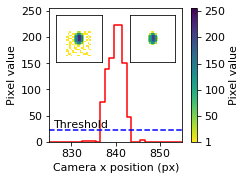

The length of one side of each square inset: 30.0 px


In [6]:
#Plot the intensity distribution horizontally across the centre of a light spot in an example image, and the threshold applied to remove background. The top left inset shows all high pixels in the original frame, and the top right inset shows the same frame after thresholding
frame_in = cv2.imread(r'..\..\..\Frames\frame_20210726_122641.jpg', cv2.IMREAD_GRAYSCALE)
frame_in = frame_in.astype(np.float32)

threshold = 0.1
frame_threshold = threshold_image(frame_in, threshold)

peak = spot_centre(frame_threshold)
r_max = spot_radius(frame_in, peak)

x_min = np.int(np.floor(peak[0] - r_max))
x_max = np.int(np.ceil(peak[0] + r_max + 1.0))
x = np.arange(x_min, x_max, 1)
y = frame_in[int(peak[1].round(0)), x_min:x_max]
threshold_value = (frame_in.max() - frame_in.min()) * threshold

fig, ax = plt.subplots(1, 1, figsize = (3.50, 2.63))
ax2 = ax.inset_axes([0.05, 0.6, 0.35, 0.35])
ax3 = ax.inset_axes([0.6, 0.6, 0.35, 0.35])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

ax.step(x, y, 'r-', where = 'mid')
ax.axhline(y = threshold_value, linestyle = '--', color = 'b')
ax.text(x_min + 1.0, 1.2 * threshold_value, 'Threshold')

colmap = matplotlib.cm.viridis_r
colmap.set_bad(color = 'white')

frame_in[frame_in == 0] = np.nan
graph = ax2.imshow(frame_in, cmap = colmap, vmin = 1.0, vmax = 255.0)
frame_threshold[frame_threshold == 0] = np.nan
ax3.imshow(frame_threshold, cmap = colmap, vmin = 1.0, vmax = 255.0)

cbar = fig.colorbar(graph, ticks = [1, 50, 100, 150, 200, 250])
cbar.set_label('Pixel value')

ax.set_xlim([np.min(x), np.max(x)])
ax.set_ylim([0.0, 255.0])
ax2.set_xlim([peak[0] - np.floor(r_max * 1.1), peak[0] + np.floor(r_max * 1.1)])
ax2.set_ylim([peak[1] - np.floor(r_max * 1.1), peak[1] + np.floor(r_max * 1.1)])
ax3.set_xlim([peak[0] - np.floor(r_max * 1.1), peak[0] + np.floor(r_max * 1.1)])
ax3.set_ylim([peak[1] - np.floor(r_max * 1.1), peak[1] + np.floor(r_max * 1.1)])

ax.set_yticks([0, 50, 100, 150, 200, 250])
ax2.set_aspect(1)
ax3.set_aspect(1)

ax.set_xlabel('Camera x position (px)')
ax.set_ylabel('Pixel value')

plt.tight_layout()
plt.savefig('example_image.png', bbox_inches = 'tight', dpi = 1200)
plt.show()

print('The length of one side of each square inset: {} px'.format(2.0 * np.floor(r_max * 1.1)))